In [1]:
from jaxstar import mistfit
from jaxstar.utils import *
from jax import random
import arviz, corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [2]:
#ticid, teff_obs, feh_obs = 120826158, 6156, 0.2   # TOI-4495
ticid, teff_obs, feh_obs = 384984325, 5663, -0.09 # TOI-6109

## query TIC and Gaia info

In [3]:
tic = Catalogs.query_criteria(catalog="TIC", ID=ticid).to_pandas()

In [4]:
import astropy.units as u
from astropy.coordinates import SkyCoord
coord = SkyCoord(ra=tic.ra[0], dec=tic.dec[0], unit=(u.degree, u.degree), frame='icrs')

In [5]:
job = Gaia.cone_search(coord, radius=5*u.arcsec)

In [6]:
gaia = job.get_results().to_pandas()

In [7]:
gaia

,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist
0,1636042515805110273,Gaia EDR3 241035596174886016,241035596174886016,1682237031,2016.0,50.131926,0.013905,42.606952,0.013043,6.733507,...,1.528513,6,5750.0,4.5,0.0,150.07156,-12.273368,59.076001,23.353074,0.000168


In [8]:
# parallax
parallax_obs = float(correct_gedr3_parallax_zeropoint(gaia))
parallax_err = float(correct_gedr3_parallax_error(gaia['parallax_error'], gaia['phot_g_mean_mag']))

In [9]:
# Kmag
tickeys = ['Kmag', 'e_Kmag', 'TWOMflag']
kmag, kmagerr, flag = np.array(tic[tickeys])[0].T
kmag, kmagerr, flag

(9.251, 0.022, 'AAA-222-111-000-0-0')

In [10]:
# correct extinction
ak, ak_err = extinction_mag_vector(gaia['l'], gaia['b'], 1e3/parallax_obs)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 27.140 s
  pix_info:   0.331 s
   samples:  14.780 s
      best:   2.963 s
       nan:   0.039 s
      sort:   8.948 s
       idx:   0.078 s
# bayestar2019 is used.


In [11]:
ak, ak_err

(array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [12]:
kmag_obs = kmag - ak[-1]
kmag_err = np.sqrt(kmagerr**2 + ak_err[-1]**2)

## other data

In [13]:
teff_err, feh_err = 100, 0.1

## fitting

In [14]:
mf = mistfit.MistFit()

In [15]:
mf.set_data(['kmag', 'teff', 'feh', 'parallax'],\
            [kmag_obs, teff_obs, feh_obs, parallax_obs],\
            [kmag_err, teff_err, feh_err, parallax_err])

In [16]:
# setup HMC
ns = 20000
mf.setup_hmc(num_warmup=ns, num_samples=ns)

In [17]:
# run
rng_key = random.PRNGKey(0)
mf.run_hmc(rng_key, linear_age=True, flat_age_marginal=False, nodata=False)

sample: 100%|█████████████████████████████████████████████████████████████| 40000/40000 [00:22<00:00, 1754.25it/s, 7 steps of size 1.78e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       age      7.18      3.31      7.24      2.32     13.29   3208.69      1.00
  distance      0.15      0.00      0.15      0.15      0.15   7810.68      1.00
       eep    367.12     27.69    371.69    333.94    407.01   2765.60      1.00
       feh     -0.06      0.09     -0.06     -0.22      0.08   5008.00      1.00

Number of divergences: 0


In [18]:
mcmc = mf.mcmc
samples = mf.samples

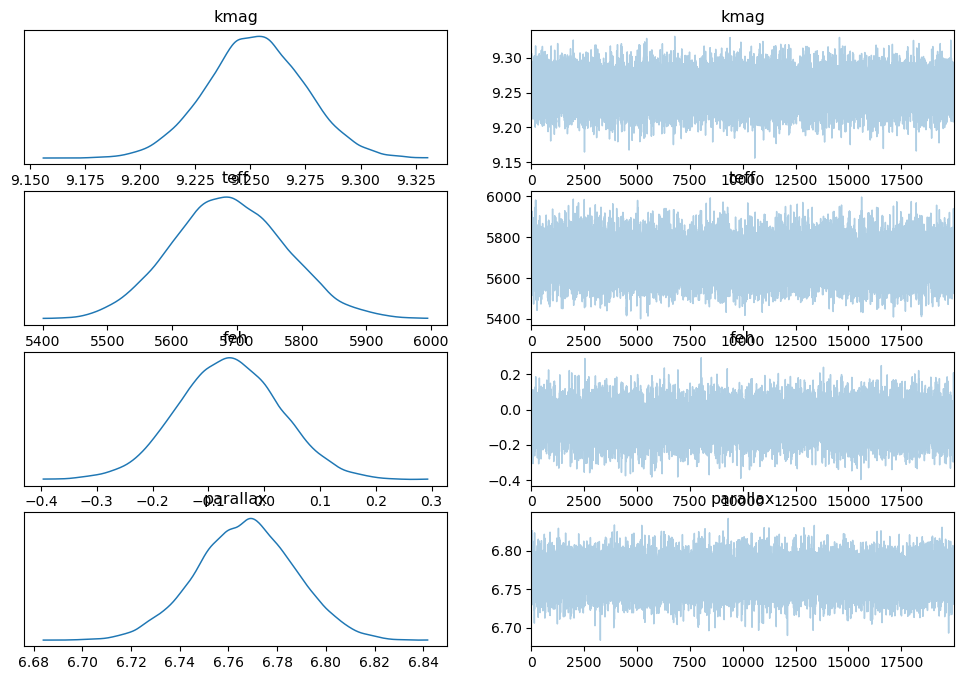

In [19]:
# trace plot
fig = arviz.plot_trace(mcmc, var_names=mf.obskeys)

In [20]:
# keys and observed values for corner plot
outkeys = mf.obskeys + ['mass', 'radius', 'age', 'eep']
obsvals = mf.obsvals + [None] * 4

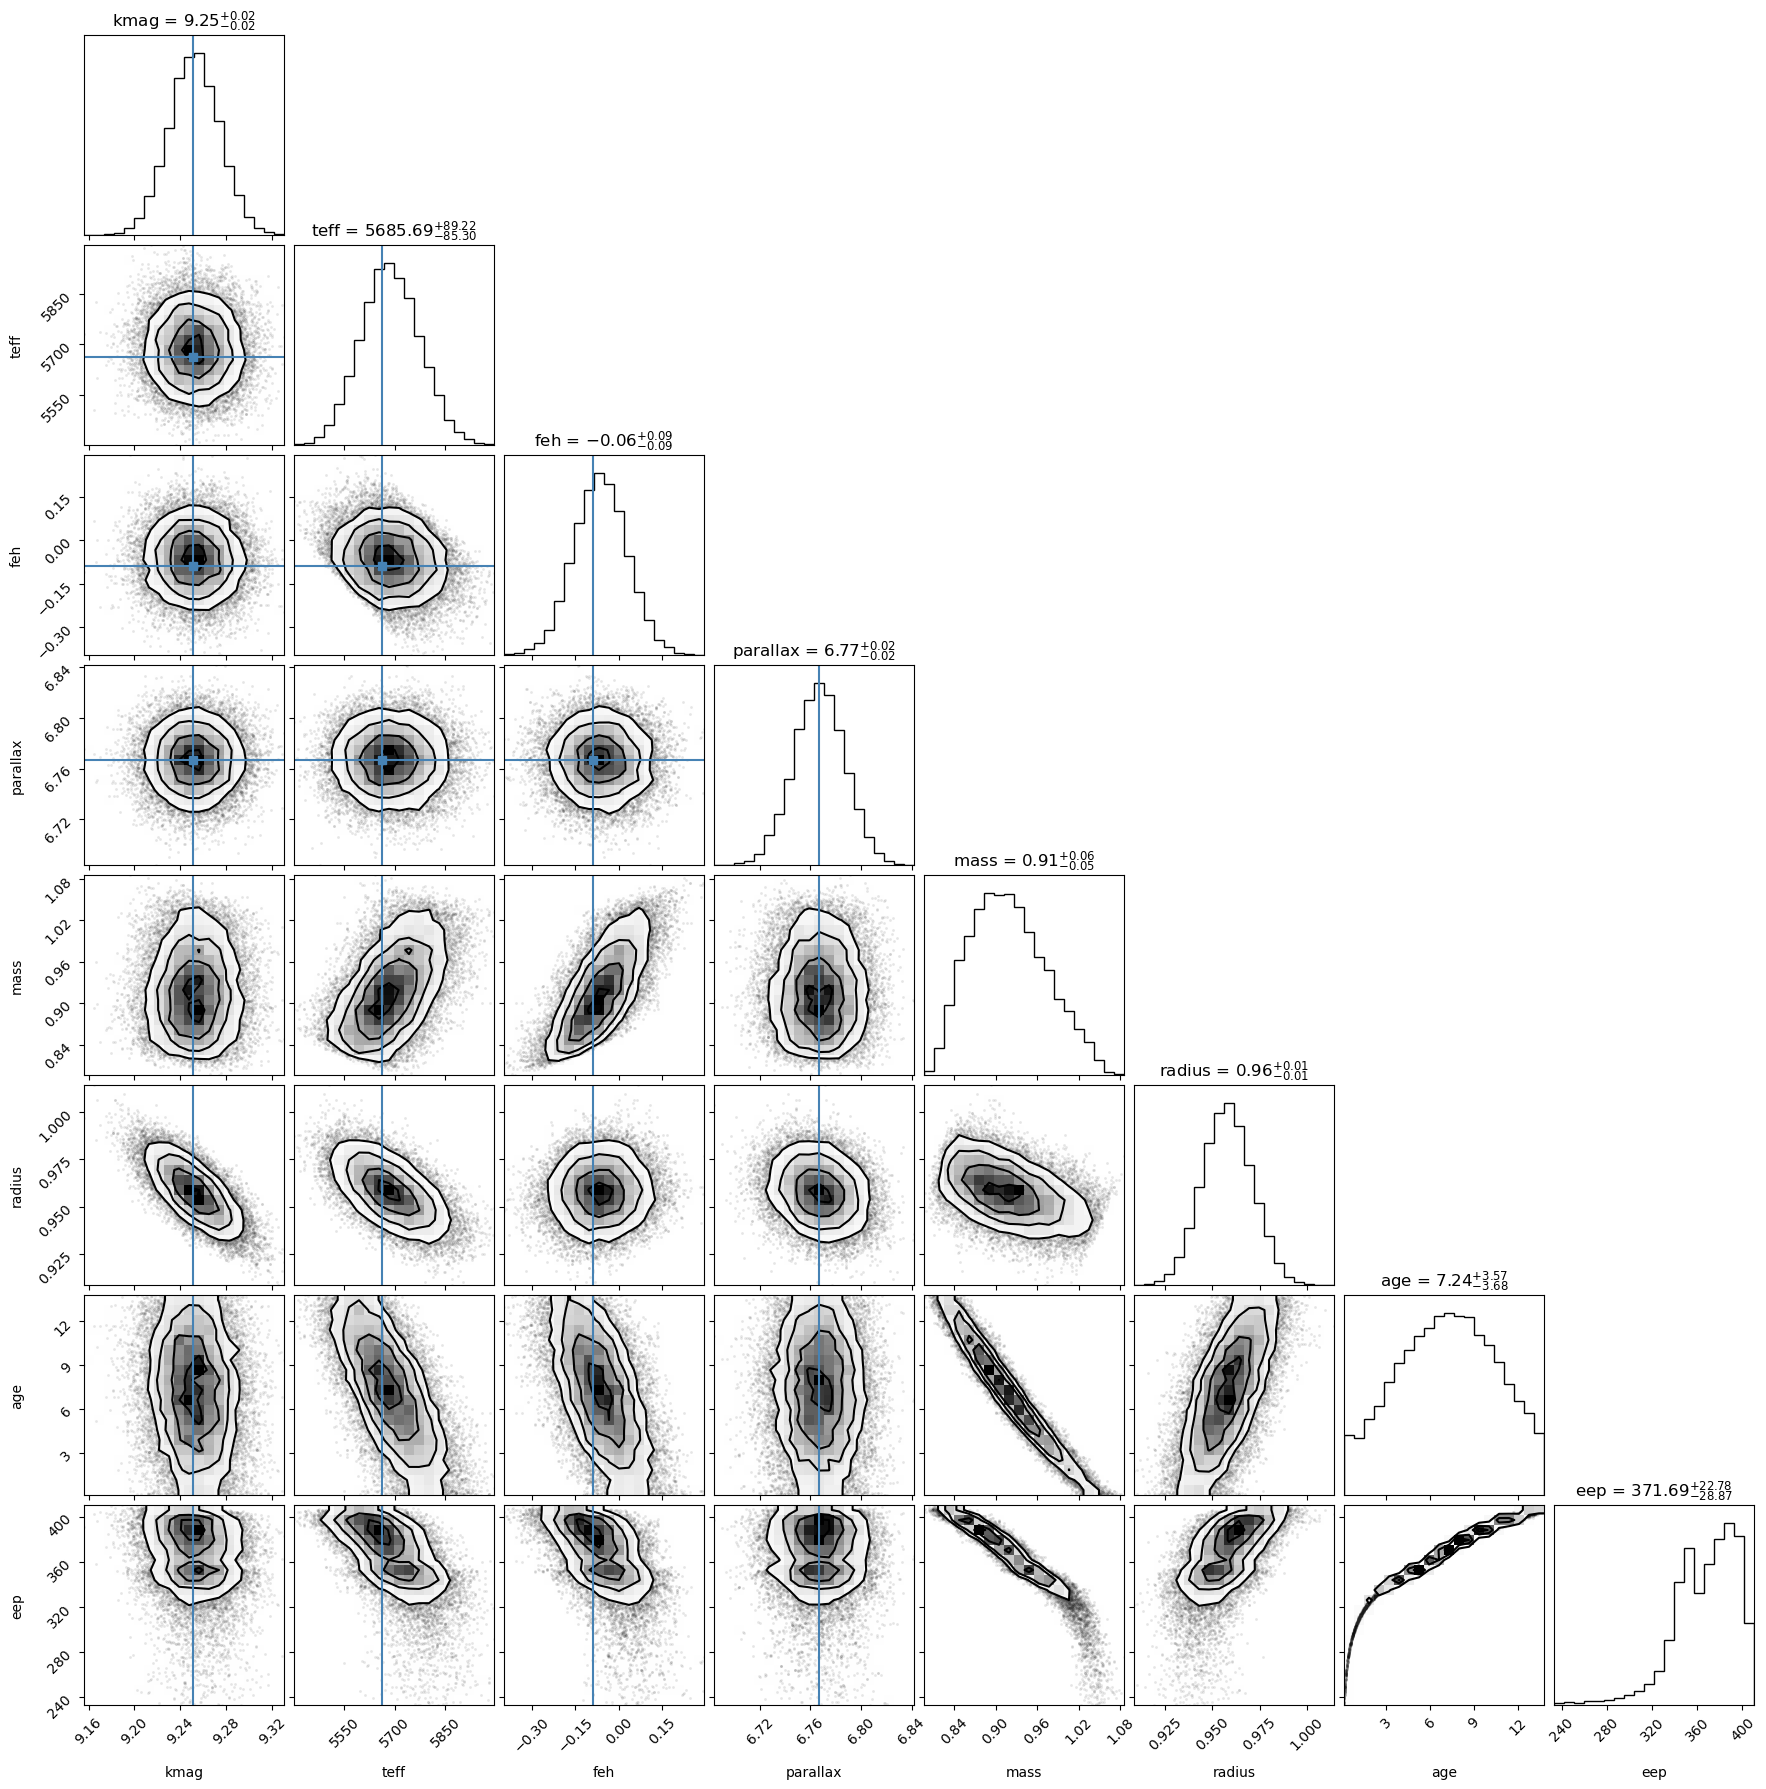

In [21]:
params = pd.DataFrame(data=dict(zip(outkeys, [samples[k] for k in outkeys])))
fig = corner.corner(params, show_titles="%.2f", truths=obsvals)
plt.savefig("%s_corner.png"%ticid, dpi=200, bbox_inches="tight")

In [22]:
params_out = pd.DataFrame(data=dict(zip(outkeys+['logg'], [samples[k] for k in outkeys+['logg']])))

In [23]:
params_out

,kmag,teff,feh,parallax,mass,radius,age,eep,logg
0,9.235132,5613.433105,-0.085954,6.764665,0.871833,0.973899,10.656109,394.490753,4.401392
1,9.264097,5592.318359,-0.087047,6.765590,0.866714,0.963141,10.755877,393.127808,4.408484
2,9.243459,5619.467773,-0.138189,6.768236,0.851356,0.970412,11.679466,398.998260,4.394164
3,9.259861,5620.502441,-0.060845,6.754021,0.888571,0.962810,9.282248,385.605347,4.419623
4,9.240356,5717.029785,-0.209658,6.773126,0.853515,0.962000,10.505415,394.479553,4.402860
...,...,...,...,...,...,...,...,...,...
19995,9.224481,5655.575684,0.011634,6.756938,0.937517,0.973106,6.763764,369.258026,4.433716
19996,9.235263,5714.601562,-0.046358,6.759849,0.935280,0.963084,6.171576,363.212585,4.441648
19997,9.246723,5531.188965,-0.009844,6.772287,0.878701,0.974795,10.917118,394.036316,4.403996
19998,9.282618,5666.608398,-0.036035,6.780213,0.926816,0.943765,6.140821,358.871796,4.455322


In [24]:
params_out.to_csv("%s_samples.csv"%ticid, index=False)